Maximum stable dt: 0.0000029752
Using dt: 0.0000029752 with 27626 time steps
CFL ratio: 1.0000 (<= 1.0)
Solved in 19.82s   (max Δ = 4.99e+00)


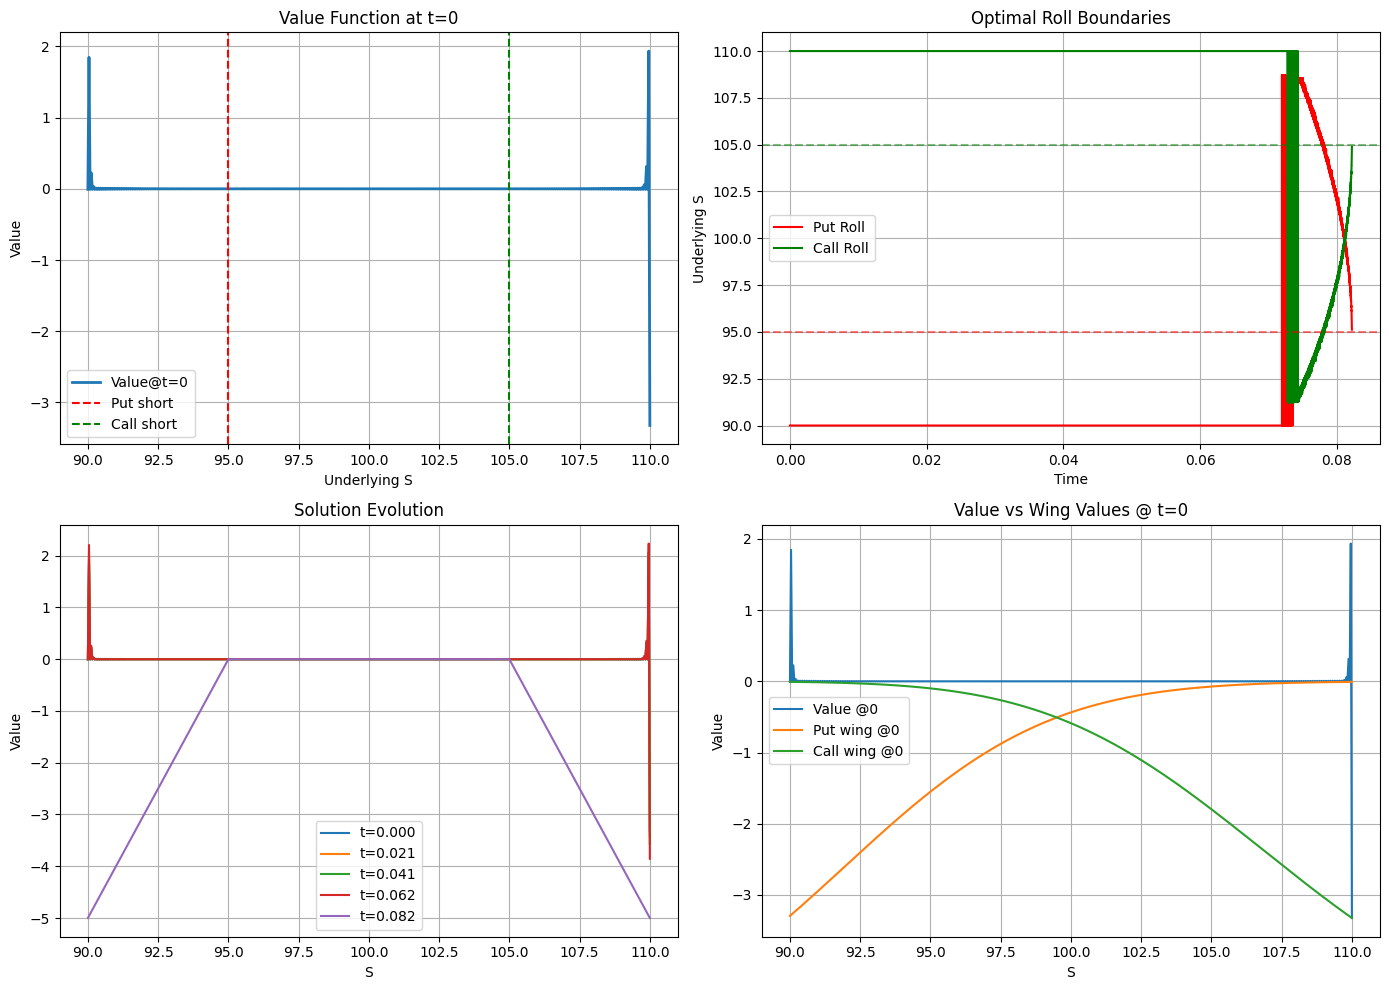

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import solve_banded
import time
import math
from numba import njit

# --- Numba-compiled helpers ------------------------------------------
@njit
def _cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

@njit
def bs_call_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(S - K, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma * sigma) * tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma * math.sqrt(tau)
    return S * _cdf(d1) - K * math.exp(-r * tau) * _cdf(d2)

@njit
def bs_put_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(K - S, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma * sigma) * tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma * math.sqrt(tau)
    return K * math.exp(-r * tau) * _cdf(-d2) - S * _cdf(-d1)

@njit
def challenged_put_numba(S, t, Kp_long, Kp_short, r, sigma, T):
    tau = T - t
    return -bs_put_numba(S, Kp_short, r, sigma, tau) \
           + bs_put_numba(S, Kp_long,   r, sigma, tau)

@njit
def challenged_call_numba(S, t, Kc_short, Kc_long, r, sigma, T):
    tau = T - t
    return -bs_call_numba(S, Kc_short, r, sigma, tau) \
           + bs_call_numba(S, Kc_long,   r, sigma, tau)

@njit
def iron_condor_payoff_numba(S, t,
                             Kp_long, Kp_short,
                             Kc_short, Kc_long,
                             r, sigma, T):
    tau = T - t
    return (
        bs_put_numba(S, Kp_long,  r, sigma, tau)
      - bs_put_numba(S, Kp_short, r, sigma, tau)
      - bs_call_numba(S, Kc_short, r, sigma, tau)
      + bs_call_numba(S, Kc_long,  r, sigma, tau)
    )

# --- Main class -------------------------------------------------------
class IronCondorOptimalRoll:
    def __init__(self, S0, r, sigma, T,
                 K_put_long, K_put_short,
                 K_call_short, K_call_long):
        self.S0    = S0
        self.r     = r
        self.sigma = sigma
        self.T     = T
        self.Kp_long,  self.Kp_short  = K_put_long,  K_put_short
        self.Kc_short, self.Kc_long   = K_call_short, K_call_long

        # pack args for numba calls
        self._args_payoff = (self.Kp_long, self.Kp_short,
                             self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)
        self._args_put    = (self.Kp_long, self.Kp_short,
                             self.r, self.sigma, self.T)
        self._args_call   = (self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)

    def setup_grid(self, S_min, S_max, Ns, Nt):
        self.S_min, self.S_max = S_min, S_max
        self.Ns,    self.Nt    = Ns, Nt
        self.dS = (S_max - S_min) / Ns

        # CFL‐based dt stability
        dt_max = 0.9 * (self.dS**2) / (self.sigma**2 * S_max**2)
        print(f"Maximum stable dt: {dt_max:.10f}")
        self.dt = min(self.T/Nt, dt_max)
        self.Nt = int(self.T/self.dt) + 1
        self.dt = self.T / self.Nt
        print(f"Using dt: {self.dt:.10f} with {self.Nt} time steps")
        print(f"CFL ratio: {self.dt/dt_max:.4f} (<= 1.0)")

        # build grids
        self.S_grid = np.linspace(S_min, S_max, Ns+1)
        self.t_grid = np.linspace(0.0, self.T, self.Nt+1)

        # allocate storage
        self.J         = np.zeros((self.Nt+1, Ns+1))
        self.roll_put  = np.full(self.Nt+1, np.nan)
        self.roll_call = np.full(self.Nt+1, np.nan)

    def build_coeffs(self):
        a = np.zeros(self.Ns+1)
        b = np.zeros(self.Ns+1)
        c = np.zeros(self.Ns+1)
        for i in range(1, self.Ns):
            S     = self.S_grid[i]
            alpha = 0.5 * self.sigma**2 * S**2 / self.dS**2
            beta  =     self.r       * S      / (2*self.dS)
            a[i]  = self.dt*(alpha - beta)
            b[i]  = 1 + self.dt*(2*alpha + self.r)
            c[i]  = self.dt*(alpha + beta)
        b[0] = b[self.Ns] = 1.0
        return a, b, c

    def _solve_tridiagonal(self, a, b, c, d):
        n = len(d)
        ab = np.zeros((3, n))
        ab[0, 1:] = c[:-1]
        ab[1, :]  = b
        ab[2, :-1]= a[1:]
        return solve_banded((1,1), ab, d)

    def solve(self):
        start = time.time()

        # terminal payoff at t=T
        for i, S in enumerate(self.S_grid):
            self.J[-1, i] = iron_condor_payoff_numba(S, self.T, *self._args_payoff)

        a, b, c = self.build_coeffs()
        max_diff = np.zeros(self.Nt)

        # backward induction
        for n in range(self.Nt-1, -1, -1):
            t     = self.t_grid[n]
            Jnext = self.J[n+1]

            # build RHS with boundary payoffs
            d = Jnext.copy()
            d[0]   = iron_condor_payoff_numba(self.S_min, t, *self._args_payoff)
            d[-1]  = iron_condor_payoff_numba(self.S_max, t, *self._args_payoff)

            # implicit PDE solve
            Jcont = self._solve_tridiagonal(a, b, c, d)
            self.J[n] = Jcont

            put_pts  = []
            call_pts = []

            # --- FIXED: this inner loop must live _inside_ the n‐loop ---
            # Always compare both wings everywhere
            for i, S in enumerate(self.S_grid):
                # put‐wing candidate
                val_put = challenged_put_numba(S, t, *self._args_put)
                if val_put > Jcont[i]:
                    self.J[n, i] = val_put
                    put_pts.append(i)
                # call‐wing candidate
                val_call = challenged_call_numba(S, t, *self._args_call)
                if val_call > Jcont[i]:
                    self.J[n, i] = val_call
                    call_pts.append(i)

            # record the extremal roll points
            if put_pts:
                self.roll_put[n]  = self.S_grid[min(put_pts)]
            if call_pts:
                self.roll_call[n] = self.S_grid[max(call_pts)]

            max_diff[n] = np.max(np.abs(self.J[n] - Jcont))

        print(f"Solved in {time.time()-start:.2f}s   (max Δ = {max_diff.max():.2e})")

    def plot_results(self):
        fig, axes = plt.subplots(2,2,figsize=(14,10))

        # Value @ t=0
        ax = axes[0,0]
        ax.plot(self.S_grid, self.J[0], lw=2, label='Value@t=0')
        ax.axvline(self.Kp_short, color='r', ls='--', label='Put short')
        ax.axvline(self.Kc_short, color='g', ls='--', label='Call short')
        ax.set(title='Value Function at t=0', xlabel='Underlying S', ylabel='Value')
        ax.grid(); ax.legend()

        # Optimal roll boundaries
        ax = axes[0,1]
        vp = ~np.isnan(self.roll_put)
        vc = ~np.isnan(self.roll_call)
        if vp.any(): ax.plot(self.t_grid[vp], self.roll_put[vp], 'r-', label='Put Roll')
        if vc.any(): ax.plot(self.t_grid[vc], self.roll_call[vc], 'g-', label='Call Roll')
        ax.axhline(self.Kp_short, color='r', ls='--', alpha=0.5)
        ax.axhline(self.Kc_short, color='g', ls='--', alpha=0.5)
        ax.set(title='Optimal Roll Boundaries', xlabel='Time', ylabel='Underlying S')
        ax.grid(); ax.legend()

        # Solution evolution
        ax = axes[1,0]
        for idx in [0, self.Nt//4, self.Nt//2, 3*self.Nt//4, self.Nt]:
            ax.plot(self.S_grid, self.J[idx], label=f't={self.t_grid[idx]:.3f}')
        ax.set(title='Solution Evolution', xlabel='S', ylabel='Value')
        ax.grid(); ax.legend()

        # Value vs wing values at t=0
        ax = axes[1,1]
        putv  = np.array([challenged_put_numba (S, 0.0, *self._args_put ) for S in self.S_grid])
        callv = np.array([challenged_call_numba(S, 0.0, *self._args_call) for S in self.S_grid])
        ax.plot(self.S_grid, self.J[0],   label='Value @0')
        ax.plot(self.S_grid, putv,  label='Put wing @0')
        ax.plot(self.S_grid, callv, label='Call wing @0')
        ax.set(title='Value vs Wing Values @ t=0', xlabel='S', ylabel='Value')
        ax.grid(); ax.legend()

        plt.tight_layout()
        plt.show()


# === Example usage ===
if __name__=="__main__":
    S0, r, sigma, T = 100, 0.05, 0.2, 30/365
    Kp_long, Kp_short = 90, 95
    Kc_short, Kc_long = 105, 110

    solver = IronCondorOptimalRoll(
        S0, r, sigma, T,
        Kp_long, Kp_short,
        Kc_short, Kc_long
    )
    solver.setup_grid(90, 110, Ns=500, Nt=200)
    solver.solve()
    solver.plot_results()


Maximum stable dt: 0.0000029752
Using dt: 0.0000029752 over 27626 steps
Solved in 20.88s  (max Δ=4.99e+00)


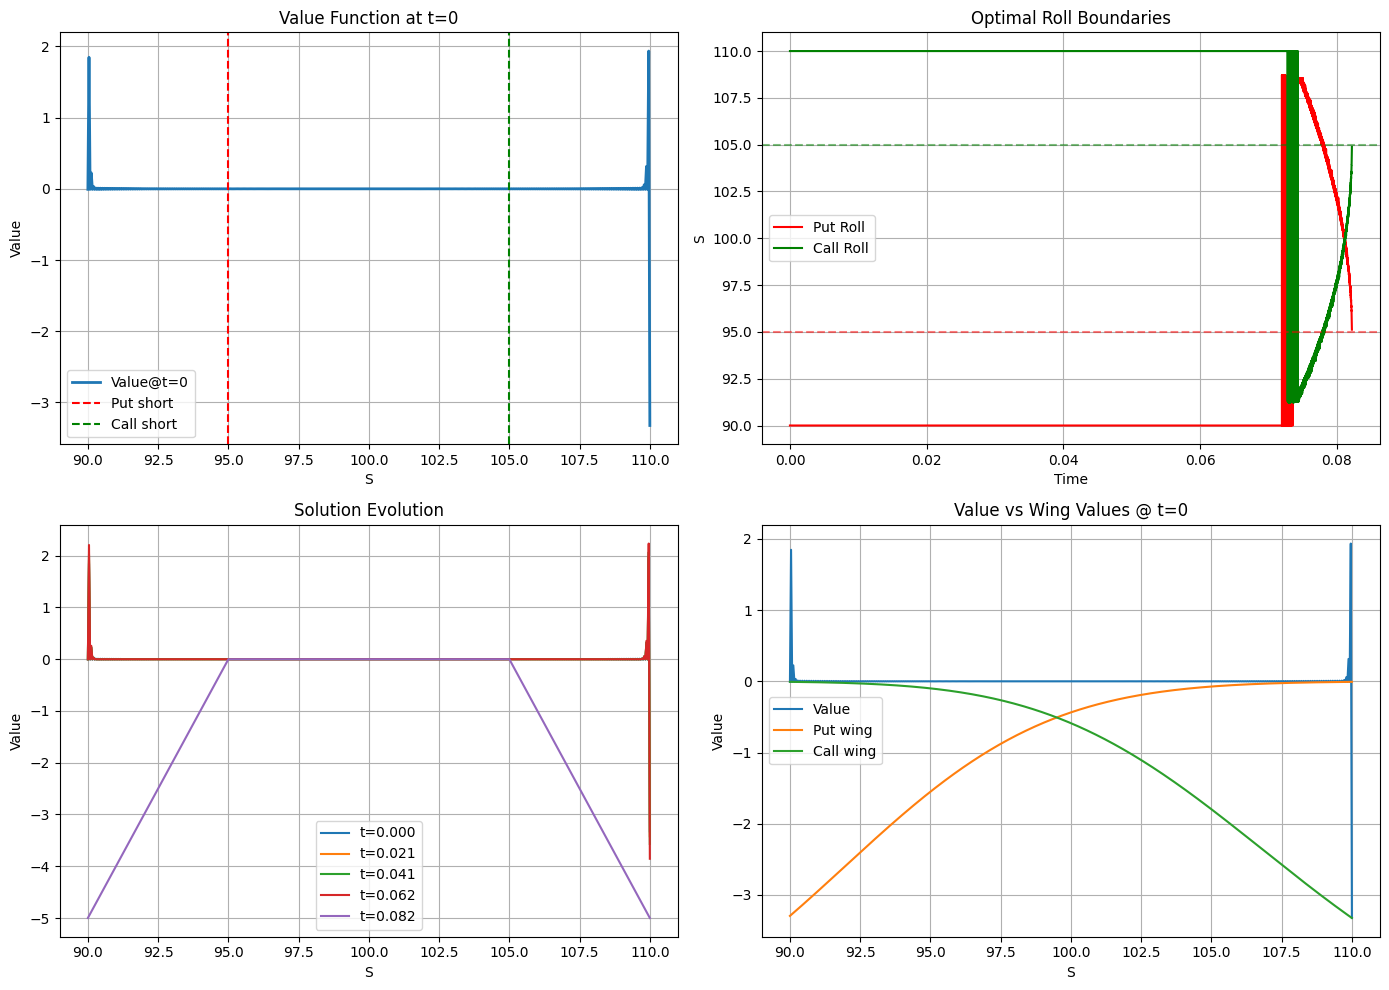

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import solve_banded
import time
import math
from numba import njit

# --- Numba-compiled helpers ------------------------------------------
@njit
def _cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

@njit
def bs_call_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(S - K, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma*sigma)*tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma*math.sqrt(tau)
    return S*_cdf(d1) - K*math.exp(-r*tau)*_cdf(d2)

@njit
def bs_put_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(K - S, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma*sigma)*tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma*math.sqrt(tau)
    return K*math.exp(-r*tau)*_cdf(-d2) - S*_cdf(-d1)

@njit
def challenged_put_numba(S, t, Kp_long, Kp_short, r, sigma, T):
    tau = T - t
    return -bs_put_numba(S, Kp_short, r, sigma, tau) \
           + bs_put_numba(S, Kp_long,   r, sigma, tau)

@njit
def challenged_call_numba(S, t, Kc_short, Kc_long, r, sigma, T):
    tau = T - t
    return -bs_call_numba(S, Kc_short, r, sigma, tau) \
           + bs_call_numba(S, Kc_long,   r, sigma, tau)

@njit
def iron_condor_payoff_numba(S, t,
                             Kp_long, Kp_short,
                             Kc_short, Kc_long,
                             r, sigma, T):
    tau = T - t
    return (
        bs_put_numba(S, Kp_long,  r, sigma, tau)
      - bs_put_numba(S, Kp_short, r, sigma, tau)
      - bs_call_numba(S, Kc_short, r, sigma, tau)
      + bs_call_numba(S, Kc_long,  r, sigma, tau)
    )

# --- Main solver class ------------------------------------------------
class IronCondorOptimalRoll:
    def __init__(self, S0, r, sigma, T,
                 K_put_long, K_put_short,
                 K_call_short, K_call_long):
        self.S0    = S0
        self.r     = r
        self.sigma = sigma
        self.T     = T
        self.Kp_long,  self.Kp_short  = K_put_long,  K_put_short
        self.Kc_short, self.Kc_long   = K_call_short, K_call_long

        # pre-pack args for numba calls
        self._args_payoff = (self.Kp_long, self.Kp_short,
                             self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)
        self._args_put    = (self.Kp_long, self.Kp_short,
                             self.r, self.sigma, self.T)
        self._args_call   = (self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)

    def setup_grid(self, S_min, S_max, Ns, Nt):
        self.S_min, self.S_max = S_min, S_max
        self.Ns,    self.Nt    = Ns, Nt
        self.dS = (S_max - S_min)/Ns

        # CFL stability
        dt_max = 0.9*(self.dS**2)/(self.sigma**2 * S_max**2)
        print(f"Maximum stable dt: {dt_max:.10f}")
        self.dt = min(self.T/Nt, dt_max)
        self.Nt = int(self.T/self.dt)+1
        self.dt = self.T/self.Nt
        print(f"Using dt: {self.dt:.10f} over {self.Nt} steps")

        # grids
        self.S_grid = np.linspace(S_min, S_max, Ns+1)
        self.t_grid = np.linspace(0.0, self.T, self.Nt+1)

        # allocate
        self.J         = np.zeros((self.Nt+1, Ns+1))
        self.roll_put  = np.full(self.Nt+1, np.nan)
        self.roll_call = np.full(self.Nt+1, np.nan)

    def build_coeffs(self):
        a = np.zeros(self.Ns+1)
        b = np.zeros(self.Ns+1)
        c = np.zeros(self.Ns+1)
        for i in range(1, self.Ns):
            S = self.S_grid[i]
            alpha = 0.5*self.sigma**2 * S**2 / self.dS**2
            beta  = self.r * S/(2*self.dS)
            a[i]  = self.dt*(alpha - beta)
            b[i]  = 1 + self.dt*(2*alpha + self.r)
            c[i]  = self.dt*(alpha + beta)
        b[0] = b[self.Ns] = 1.0
        return a, b, c

    def _solve_tridiagonal(self, a, b, c, d):
        n = len(d)
        ab = np.zeros((3, n))
        ab[0,1:] = c[:-1]
        ab[1,:]  = b
        ab[2,:-1]= a[1:]
        return solve_banded((1,1), ab, d)

    def solve(self):
        start = time.time()
        # terminal payoff
        for i, S in enumerate(self.S_grid):
            self.J[-1,i] = iron_condor_payoff_numba(S, self.T, *self._args_payoff)

        a,b,c = self.build_coeffs()
        max_diff = np.zeros(self.Nt)

        # --- time‐stepping loop ----------------------------
        for n in range(self.Nt-1, -1, -1):
            t = self.t_grid[n]
            Jn1 = self.J[n+1].copy()

            # boundary
            rhs = Jn1.copy()
            rhs[0]   = iron_condor_payoff_numba(self.S_min, t, *self._args_payoff)
            rhs[-1]  = iron_condor_payoff_numba(self.S_max, t, *self._args_payoff)

            # implicit step
            Jcont = self._solve_tridiagonal(a,b,c,rhs)
            self.J[n] = Jcont

            put_pts = []
            call_pts = []

            # ALWAYS compare both wings *inside* the time loop
            for i,S in enumerate(self.S_grid):
                vp = challenged_put_numba(S, t, *self._args_put)
                if vp > Jcont[i]:
                    self.J[n,i] = vp
                    put_pts.append(i)

                vc = challenged_call_numba(S, t, *self._args_call)
                if vc > Jcont[i]:
                    self.J[n,i] = vc
                    call_pts.append(i)

            # record boundaries
            if put_pts:
                self.roll_put[n]  = self.S_grid[min(put_pts)]
            if call_pts:
                self.roll_call[n] = self.S_grid[max(call_pts)]

            max_diff[n] = np.max(np.abs(self.J[n]-Jcont))

        print(f"Solved in {time.time()-start:.2f}s  (max Δ={max_diff.max():.2e})")

    def plot_results(self):
        fig, axes = plt.subplots(2,2,figsize=(14,10))

        # (1) Value @ t=0
        ax = axes[0,0]
        ax.plot(self.S_grid, self.J[0], lw=2, label='Value@t=0')
        ax.axvline(self.Kp_short, color='r', ls='--', label='Put short')
        ax.axvline(self.Kc_short, color='g', ls='--', label='Call short')
        ax.set(title='Value Function at t=0', xlabel='S', ylabel='Value')
        ax.grid(); ax.legend()

        # (2) Roll boundaries
        ax = axes[0,1]
        vp = ~np.isnan(self.roll_put)
        vc = ~np.isnan(self.roll_call)
        if vp.any():
            ax.plot(self.t_grid[vp], self.roll_put[vp], 'r-', label='Put Roll')
        if vc.any():
            ax.plot(self.t_grid[vc], self.roll_call[vc], 'g-', label='Call Roll')
        ax.axhline(self.Kp_short, color='r', ls='--', alpha=0.5)
        ax.axhline(self.Kc_short, color='g', ls='--', alpha=0.5)
        ax.set(title='Optimal Roll Boundaries', xlabel='Time', ylabel='S')
        ax.grid(); ax.legend()

        # (3) Evolution
        ax = axes[1,0]
        for idx in [0, self.Nt//4, self.Nt//2, 3*self.Nt//4, self.Nt]:
            ax.plot(self.S_grid, self.J[idx], label=f't={self.t_grid[idx]:.3f}')
        ax.set(title='Solution Evolution', xlabel='S', ylabel='Value')
        ax.grid(); ax.legend()

        # (4) Value vs wings @ t=0
        ax = axes[1,1]
        putv  = np.array([challenged_put_numba(S,0.0,*self._args_put)  for S in self.S_grid])
        callv = np.array([challenged_call_numba(S,0.0,*self._args_call) for S in self.S_grid])
        ax.plot(self.S_grid, self.J[0],   label='Value')
        ax.plot(self.S_grid, putv,  label='Put wing')
        ax.plot(self.S_grid, callv, label='Call wing')
        ax.set(title='Value vs Wing Values @ t=0', xlabel='S', ylabel='Value')
        ax.grid(); ax.legend()

        plt.tight_layout()
        plt.show()


# === Example usage ===
if __name__=="__main__":
    S0, r, sigma, T = 100, 0.05, 0.2, 30/365
    Kp_long, Kp_short = 90, 95
    Kc_short, Kc_long = 105, 110

    solver = IronCondorOptimalRoll(
        S0, r, sigma, T,
        Kp_long, Kp_short,
        Kc_short, Kc_long
    )
    solver.setup_grid(90, 110, Ns=500, Nt=200)
    solver.solve()
    solver.plot_results()


Maximum stable dt: 0.0000029752
Using dt: 0.0000029752 over 27626 steps
 time‐step 27625  t=0.0822  put_pts=249  call_pts=249
 time‐step 27624  t=0.0822  put_pts=186  call_pts=186
 time‐step 27623  t=0.0822  put_pts=186  call_pts=185
 time‐step 27622  t=0.0822  put_pts=185  call_pts=184
 time‐step 27621  t=0.0822  put_pts=184  call_pts=184
 time‐step 27620  t=0.0822  put_pts=183  call_pts=183
 time‐step 27619  t=0.0822  put_pts=183  call_pts=182
 time‐step 27618  t=0.0822  put_pts=182  call_pts=181
 time‐step 27617  t=0.0822  put_pts=181  call_pts=181
 time‐step 27616  t=0.0822  put_pts=181  call_pts=180
 time‐step 27615  t=0.0822  put_pts=180  call_pts=179
 time‐step 27614  t=0.0822  put_pts=179  call_pts=178
 time‐step 27613  t=0.0822  put_pts=178  call_pts=177
 time‐step 27612  t=0.0822  put_pts=178  call_pts=176
 time‐step 27611  t=0.0821  put_pts=177  call_pts=176
 time‐step 27610  t=0.0821  put_pts=177  call_pts=174
 time‐step 27609  t=0.0821  put_pts=177  call_pts=176
 time‐step

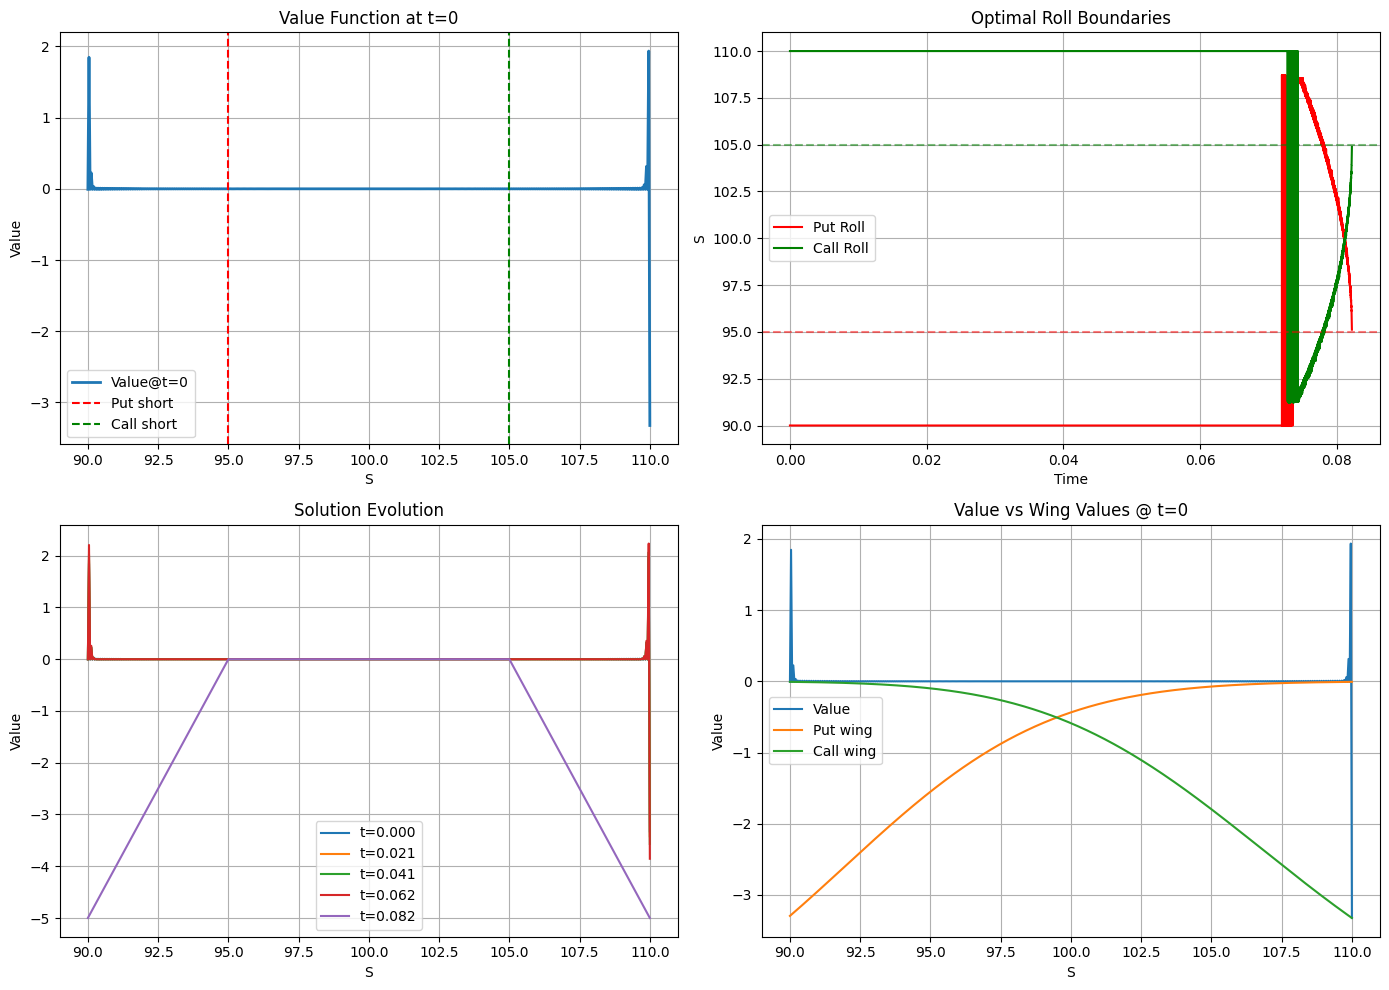

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
import time
import math
from numba import njit

# --- Numba-compiled helpers ------------------------------------------
@njit
def _cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

@njit
def bs_call_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(S - K, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma*sigma)*tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma*math.sqrt(tau)
    return S*_cdf(d1) - K*math.exp(-r*tau)*_cdf(d2)

@njit
def bs_put_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(K - S, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma*sigma)*tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma*math.sqrt(tau)
    return K*math.exp(-r*tau)*_cdf(-d2) - S*_cdf(-d1)

@njit
def challenged_put_numba(S, t, Kp_long, Kp_short, r, sigma, T):
    tau = T - t
    return -bs_put_numba(S, Kp_short, r, sigma, tau) \
           + bs_put_numba(S, Kp_long,   r, sigma, tau)

@njit
def challenged_call_numba(S, t, Kc_short, Kc_long, r, sigma, T):
    tau = T - t
    return -bs_call_numba(S, Kc_short, r, sigma, tau) \
           + bs_call_numba(S, Kc_long,   r, sigma, tau)

@njit
def iron_condor_payoff_numba(S, t,
                             Kp_long, Kp_short,
                             Kc_short, Kc_long,
                             r, sigma, T):
    tau = T - t
    return (
        bs_put_numba(S, Kp_long,  r, sigma, tau)
      - bs_put_numba(S, Kp_short, r, sigma, tau)
      - bs_call_numba(S, Kc_short, r, sigma, tau)
      + bs_call_numba(S, Kc_long,  r, sigma, tau)
    )

# --- Main solver class ------------------------------------------------
class IronCondorOptimalRoll:
    def __init__(self, S0, r, sigma, T,
                 K_put_long, K_put_short,
                 K_call_short, K_call_long):
        self.S0    = S0
        self.r     = r
        self.sigma = sigma
        self.T     = T
        self.Kp_long,  self.Kp_short  = K_put_long,  K_put_short
        self.Kc_short, self.Kc_long   = K_call_short, K_call_long

        # pre‐pack args for numba calls
        self._args_payoff = (self.Kp_long, self.Kp_short,
                             self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)
        self._args_put    = (self.Kp_long, self.Kp_short,
                             self.r, self.sigma, self.T)
        self._args_call   = (self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)

    def setup_grid(self, S_min, S_max, Ns, Nt):
        self.S_min, self.S_max = S_min, S_max
        self.Ns,    self.Nt    = Ns, Nt
        self.dS = (S_max - S_min)/Ns

        # CFL stability
        dt_max = 0.9*(self.dS**2)/(self.sigma**2 * S_max**2)
        print(f"Maximum stable dt: {dt_max:.10f}")
        self.dt = min(self.T/Nt, dt_max)
        self.Nt = int(self.T/self.dt)+1
        self.dt = self.T/self.Nt
        print(f"Using dt: {self.dt:.10f} over {self.Nt} steps")

        # grids
        self.S_grid = np.linspace(S_min, S_max, Ns+1)
        self.t_grid = np.linspace(0.0, self.T, self.Nt+1)

        # allocate
        self.J         = np.zeros((self.Nt+1, Ns+1))
        self.roll_put  = np.full(self.Nt+1, np.nan)
        self.roll_call = np.full(self.Nt+1, np.nan)

    def build_coeffs(self):
        a = np.zeros(self.Ns+1)
        b = np.zeros(self.Ns+1)
        c = np.zeros(self.Ns+1)
        for i in range(1, self.Ns):
            S = self.S_grid[i]
            alpha = 0.5*self.sigma**2 * S**2 / self.dS**2
            beta  = self.r * S/(2*self.dS)
            a[i]  = self.dt*(alpha - beta)
            b[i]  = 1 + self.dt*(2*alpha + self.r)
            c[i]  = self.dt*(alpha + beta)
        b[0] = b[self.Ns] = 1.0
        return a, b, c

    def _solve_tridiagonal(self, a, b, c, d):
        n = len(d)
        ab = np.zeros((3, n))
        ab[0,1:] = c[:-1]
        ab[1,:]  = b
        ab[2,:-1]= a[1:]
        return solve_banded((1,1), ab, d)

    def solve(self):
        start = time.time()
        # terminal payoff
        for i, S in enumerate(self.S_grid):
            self.J[-1,i] = iron_condor_payoff_numba(S, self.T, *self._args_payoff)

        a,b,c = self.build_coeffs()
        max_diff = np.zeros(self.Nt)

        for n in range(self.Nt-1, -1, -1):
            t = self.t_grid[n]
            Jn1 = self.J[n+1].copy()

            # boundary
            rhs = Jn1.copy()
            rhs[0]   = iron_condor_payoff_numba(self.S_min, t, *self._args_payoff)
            rhs[-1]  = iron_condor_payoff_numba(self.S_max, t, *self._args_payoff)

            # implicit step
            Jcont = self._solve_tridiagonal(a,b,c,rhs)
            self.J[n] = Jcont

            put_pts = []
            call_pts = []

            # ALWAYS compare both wings
            for i,S in enumerate(self.S_grid):
                vp = challenged_put_numba(S, t, *self._args_put)
                if vp > Jcont[i]:
                    self.J[n,i] = vp
                    put_pts.append(i)

                vc = challenged_call_numba(S, t, *self._args_call)
                if vc > Jcont[i]:
                    self.J[n,i] = vc
                    call_pts.append(i)

            # record boundaries & diagnostic print
            if put_pts or call_pts:
                print(f" time‐step {n:4d}  t={t:.4f}  put_pts={len(put_pts)}  call_pts={len(call_pts)}")
            if put_pts:
                self.roll_put[n]  = self.S_grid[min(put_pts)]
            if call_pts:
                self.roll_call[n] = self.S_grid[max(call_pts)]

            max_diff[n] = np.max(np.abs(self.J[n]-Jcont))

        print(f"Solved in {time.time()-start:.2f}s  (max Δ={max_diff.max():.2e})")

    def plot_results(self):
        fig, axes = plt.subplots(2,2,figsize=(14,10))

        # (1) Value @ t=0
        ax = axes[0,0]
        ax.plot(self.S_grid, self.J[0], lw=2, label='Value@t=0')
        ax.axvline(self.Kp_short, color='r', ls='--', label='Put short')
        ax.axvline(self.Kc_short, color='g', ls='--', label='Call short')
        ax.set(title='Value Function at t=0', xlabel='S', ylabel='Value')
        ax.grid(); ax.legend()

        # (2) Roll boundaries
        ax = axes[0,1]
        # only plot indices [0..Nt-1], since roll arrays were filled there
        valid_put = ~np.isnan(self.roll_put[:-1])
        valid_call= ~np.isnan(self.roll_call[:-1])
        if valid_put.any():
            ax.plot(self.t_grid[:-1][valid_put],
                    self.roll_put[:-1][valid_put], 'r-', label='Put Roll')
        if valid_call.any():
            ax.plot(self.t_grid[:-1][valid_call],
                    self.roll_call[:-1][valid_call], 'g-', label='Call Roll')
        ax.axhline(self.Kp_short, color='r', ls='--', alpha=0.5)
        ax.axhline(self.Kc_short, color='g', ls='--', alpha=0.5)
        ax.set(title='Optimal Roll Boundaries', xlabel='Time', ylabel='S')
        ax.grid(); ax.legend()

        # (3) Evolution
        ax = axes[1,0]
        for idx in [0, self.Nt//4, self.Nt//2, 3*self.Nt//4, self.Nt]:
            ax.plot(self.S_grid, self.J[idx], label=f't={self.t_grid[idx]:.3f}')
        ax.set(title='Solution Evolution', xlabel='S', ylabel='Value')
        ax.grid(); ax.legend()

        # (4) Value vs wings @ t=0
        ax = axes[1,1]
        putv  = np.array([challenged_put_numba(S,0.0,*self._args_put)  for S in self.S_grid])
        callv = np.array([challenged_call_numba(S,0.0,*self._args_call) for S in self.S_grid])
        ax.plot(self.S_grid, self.J[0],   label='Value')
        ax.plot(self.S_grid, putv,  label='Put wing')
        ax.plot(self.S_grid, callv, label='Call wing')
        ax.set(title='Value vs Wing Values @ t=0', xlabel='S', ylabel='Value')
        ax.grid(); ax.legend()

        plt.tight_layout()
        plt.show()

# === Example usage ===
if __name__=="__main__":
    S0, r, sigma, T = 100, 0.05, 0.2, 30/365
    Kp_long, Kp_short = 90, 95
    Kc_short, Kc_long = 105, 110

    solver = IronCondorOptimalRoll(
        S0, r, sigma, T,
        Kp_long, Kp_short,
        Kc_short, Kc_long
    )
    solver.setup_grid(90, 110, Ns=500, Nt=200)
    solver.solve()
    solver.plot_results()


Maximum stable dt: 0.0000029752
Using dt: 0.0000029752 over 27626 steps
[diag t=0.0822] S~Put 95.00: Jcont=0.0025, vp=-0.0185, vc=0.0000
[diag t=0.0822] S~Call105.00: Jcont=0.0024, vp=0.0000, vc=-0.0205
[diag t=0.0616] S~Put 95.00: Jcont=0.0000, vp=-1.0103, vc=-0.0002
[diag t=0.0616] S~Call105.00: Jcont=0.0000, vp=-0.0002, vc=-1.1812
[diag t=0.0411] S~Put 95.00: Jcont=0.0000, vp=-1.2973, vc=-0.0102
[diag t=0.0411] S~Call105.00: Jcont=0.0000, vp=-0.0076, vc=-1.5059
[diag t=0.0205] S~Put 95.00: Jcont=0.0000, vp=-1.4522, vc=-0.0447
[diag t=0.0205] S~Call105.00: Jcont=0.0001, vp=-0.0331, vc=-1.6820
[diag t=0.0000] S~Put 95.00: Jcont=0.0004, vp=-1.5505, vc=-0.0991
[diag t=0.0000] S~Call105.00: Jcont=0.0008, vp=-0.0733, vc=-1.7971
Solved in 20.14s  (max Δ=4.99e+00)


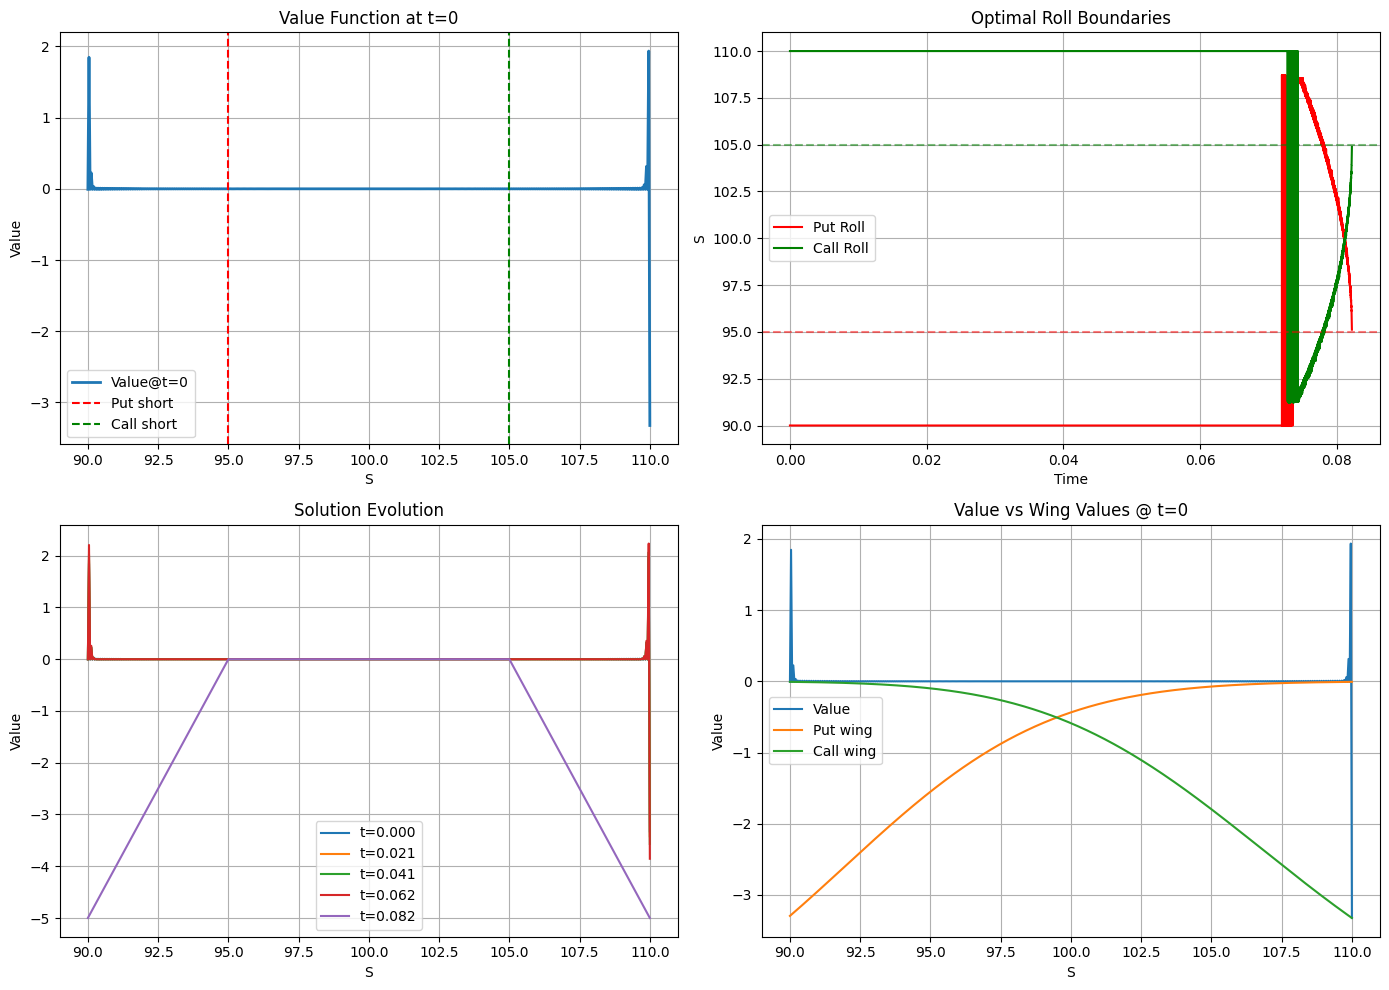

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
import time
import math
from numba import njit

# --- Numba-compiled helpers ------------------------------------------
@njit
def _cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

@njit
def bs_call_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(S - K, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma*sigma)*tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma*math.sqrt(tau)
    return S*_cdf(d1) - K*math.exp(-r*tau)*_cdf(d2)

@njit
def bs_put_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(K - S, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma*sigma)*tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma*math.sqrt(tau)
    return K*math.exp(-r*tau)*_cdf(-d2) - S*_cdf(-d1)

@njit
def challenged_put_numba(S, t, Kp_long, Kp_short, r, sigma, T):
    tau = T - t
    return -bs_put_numba(S, Kp_short, r, sigma, tau) \
           + bs_put_numba(S, Kp_long,   r, sigma, tau)

@njit
def challenged_call_numba(S, t, Kc_short, Kc_long, r, sigma, T):
    tau = T - t
    return -bs_call_numba(S, Kc_short, r, sigma, tau) \
           + bs_call_numba(S, Kc_long,   r, sigma, tau)

@njit
def iron_condor_payoff_numba(S, t,
                             Kp_long, Kp_short,
                             Kc_short, Kc_long,
                             r, sigma, T):
    tau = T - t
    return (
        bs_put_numba(S, Kp_long,  r, sigma, tau)
      - bs_put_numba(S, Kp_short, r, sigma, tau)
      - bs_call_numba(S, Kc_short, r, sigma, tau)
      + bs_call_numba(S, Kc_long,  r, sigma, tau)
    )

# --- Main solver class ------------------------------------------------
class IronCondorOptimalRoll:
    def __init__(self, S0, r, sigma, T,
                 K_put_long, K_put_short,
                 K_call_short, K_call_long):
        self.S0    = S0
        self.r     = r
        self.sigma = sigma
        self.T     = T
        self.Kp_long, self.Kp_short = K_put_long, K_put_short
        self.Kc_short, self.Kc_long = K_call_short, K_call_long

        # pre-pack args for numba calls
        self._args_payoff = (self.Kp_long, self.Kp_short,
                             self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)
        self._args_put    = (self.Kp_long, self.Kp_short,
                             self.r, self.sigma, self.T)
        self._args_call   = (self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)

    def setup_grid(self, S_min, S_max, Ns, Nt):
        self.S_min, self.S_max = S_min, S_max
        self.Ns, self.Nt = Ns, Nt
        self.dS = (S_max - S_min)/Ns

        dt_max = 0.9*(self.dS**2)/(self.sigma**2 * S_max**2)
        print(f"Maximum stable dt: {dt_max:.10f}")
        self.dt = min(self.T/Nt, dt_max)
        self.Nt = int(self.T/self.dt)+1
        self.dt = self.T/self.Nt
        print(f"Using dt: {self.dt:.10f} over {self.Nt} steps")

        self.S_grid = np.linspace(S_min, S_max, Ns+1)
        self.t_grid = np.linspace(0.0, self.T, self.Nt+1)

        self.J         = np.zeros((self.Nt+1, Ns+1))
        self.roll_put  = np.full(self.Nt+1, np.nan)
        self.roll_call = np.full(self.Nt+1, np.nan)

    def build_coeffs(self):
        a = np.zeros(self.Ns+1)
        b = np.zeros(self.Ns+1)
        c = np.zeros(self.Ns+1)
        for i in range(1, self.Ns):
            S = self.S_grid[i]
            alpha = 0.5*self.sigma**2 * S**2 / self.dS**2
            beta  = self.r * S/(2*self.dS)
            a[i]  = self.dt*(alpha - beta)
            b[i]  = 1 + self.dt*(2*alpha + self.r)
            c[i]  = self.dt*(alpha + beta)
        b[0] = b[self.Ns] = 1.0
        return a, b, c

    def _solve_tridiagonal(self, a, b, c, d):
        n = len(d)
        ab = np.zeros((3, n))
        ab[0,1:] = c[:-1]
        ab[1,:]  = b
        ab[2,:-1]= a[1:]
        return solve_banded((1,1), ab, d)

    def solve(self):
        start = time.time()
        for i, S in enumerate(self.S_grid):
            self.J[-1,i] = iron_condor_payoff_numba(S, self.T, *self._args_payoff)

        a,b,c = self.build_coeffs()
        max_diff = np.zeros(self.Nt)

        for n in range(self.Nt-1, -1, -1):
            t = self.t_grid[n]
            Jn1 = self.J[n+1].copy()

            rhs = Jn1.copy()
            rhs[0]   = iron_condor_payoff_numba(self.S_min, t, *self._args_payoff)
            rhs[-1]  = iron_condor_payoff_numba(self.S_max, t, *self._args_payoff)

            Jcont = self._solve_tridiagonal(a,b,c,rhs)
            self.J[n] = Jcont

            put_pts = []
            call_pts = []

            # --- Diagnostic prints at key t, S (step 1) -------------
            if n % (self.Nt//4) == 0:
                idx_p = np.argmin(np.abs(self.S_grid - self.Kp_short))
                idx_c = np.argmin(np.abs(self.S_grid - self.Kc_short))
                Sp = self.S_grid[idx_p];  Sc = self.S_grid[idx_c]
                vp_Sp = challenged_put_numba(Sp, t, *self._args_put)
                vc_Sp = challenged_call_numba(Sp, t, *self._args_call)
                vp_Sc = challenged_put_numba(Sc, t, *self._args_put)
                vc_Sc = challenged_call_numba(Sc, t, *self._args_call)
                print(f"[diag t={t:.4f}] S~Put {Sp:.2f}: Jcont={Jcont[idx_p]:.4f}, vp={vp_Sp:.4f}, vc={vc_Sp:.4f}")
                print(f"[diag t={t:.4f}] S~Call{Sc:.2f}: Jcont={Jcont[idx_c]:.4f}, vp={vp_Sc:.4f}, vc={vc_Sc:.4f}")
            # ---------------------------------------------------------

            for i,S in enumerate(self.S_grid):
                vp = challenged_put_numba(S, t, *self._args_put)
                if vp > Jcont[i]:
                    self.J[n,i] = vp
                    put_pts.append(i)

                vc = challenged_call_numba(S, t, *self._args_call)
                if vc > Jcont[i]:
                    self.J[n,i] = vc
                    call_pts.append(i)

            if put_pts:
                self.roll_put[n]  = self.S_grid[min(put_pts)]
            if call_pts:
                self.roll_call[n] = self.S_grid[max(call_pts)]

            max_diff[n] = np.max(np.abs(self.J[n]-Jcont))

        print(f"Solved in {time.time()-start:.2f}s  (max Δ={max_diff.max():.2e})")

    def plot_results(self):
        fig, axes = plt.subplots(2,2,figsize=(14,10))

        ax = axes[0,0]
        ax.plot(self.S_grid, self.J[0], lw=2, label='Value@t=0')
        ax.axvline(self.Kp_short, color='r', ls='--', label='Put short')
        ax.axvline(self.Kc_short, color='g', ls='--', label='Call short')
        ax.set(title='Value Function at t=0', xlabel='S', ylabel='Value')
        ax.grid(); ax.legend()

        ax = axes[0,1]
        valid_put = ~np.isnan(self.roll_put[:-1])
        valid_call= ~np.isnan(self.roll_call[:-1])
        if valid_put.any():
            ax.plot(self.t_grid[:-1][valid_put], self.roll_put[:-1][valid_put], 'r-', label='Put Roll')
        if valid_call.any():
            ax.plot(self.t_grid[:-1][valid_call], self.roll_call[:-1][valid_call], 'g-', label='Call Roll')
        ax.axhline(self.Kp_short, color='r', ls='--', alpha=0.5)
        ax.axhline(self.Kc_short, color='g', ls='--', alpha=0.5)
        ax.set(title='Optimal Roll Boundaries', xlabel='Time', ylabel='S')
        ax.grid(); ax.legend()

        ax = axes[1,0]
        for idx in [0, self.Nt//4, self.Nt//2, 3*self.Nt//4, self.Nt]:
            ax.plot(self.S_grid, self.J[idx], label=f't={self.t_grid[idx]:.3f}')
        ax.set(title='Solution Evolution', xlabel='S', ylabel='Value')
        ax.grid(); ax.legend()

        ax = axes[1,1]
        putv  = np.array([challenged_put_numba(S,0.0,*self._args_put)  for S in self.S_grid])
        callv = np.array([challenged_call_numba(S,0.0,*self._args_call) for S in self.S_grid])
        ax.plot(self.S_grid, self.J[0],   label='Value')
        ax.plot(self.S_grid, putv,  label='Put wing')
        ax.plot(self.S_grid, callv, label='Call wing')
        ax.set(title='Value vs Wing Values @ t=0', xlabel='S', ylabel='Value')
        ax.grid(); ax.legend()

        plt.tight_layout()
        plt.show()

# === Example usage ===
if __name__=="__main__":
    S0, r, sigma, T = 100, 0.05, 0.2, 30/365
    Kp_long, Kp_short = 90, 95
    Kc_short, Kc_long = 105, 110

    solver = IronCondorOptimalRoll(
        S0, r, sigma, T,
        Kp_long, Kp_short,
        Kc_short, Kc_long
    )
    solver.setup_grid(90, 110, Ns=500, Nt=200)
    solver.solve()
    solver.plot_results()



Maximum stable dt: 8.264462809917354e-06
Using dt=0.000008 over 9946 steps
Solved in 2467.13s  (max Δ=6.96e+02)


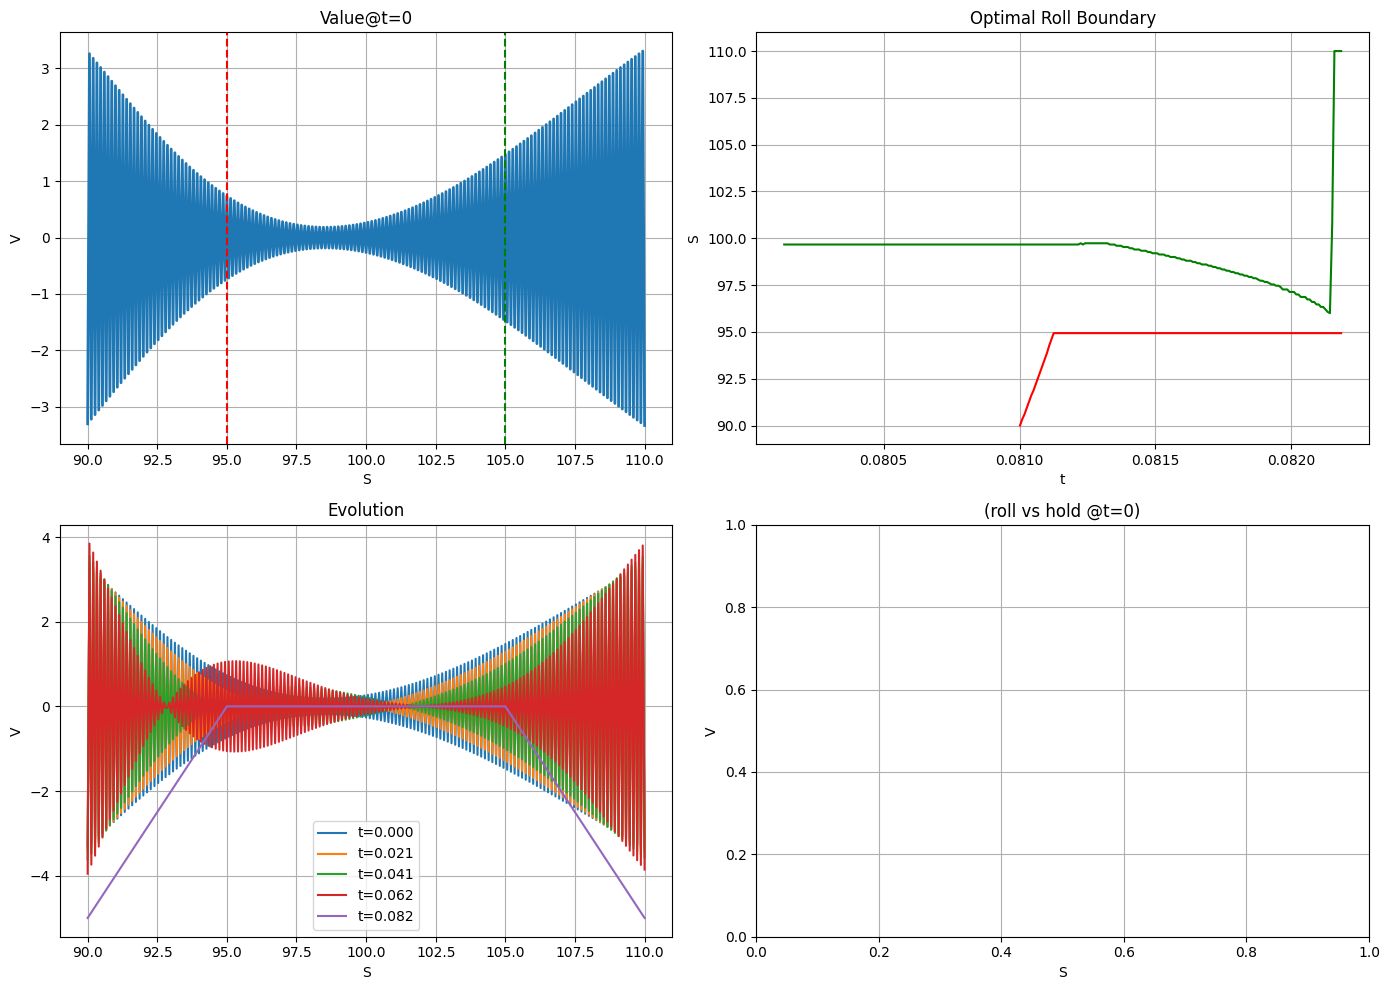

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from scipy.optimize import brentq
from scipy.stats import norm
import time
import math
from numba import njit

# --- Numba‐compiled pricing helpers -----------------------------------
@njit
def _cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

@njit
def bs_call_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(S - K, 0.0)
    d1 = (math.log(S/K) + (r + 0.5*sigma*sigma)*tau)/(sigma*math.sqrt(tau))
    d2 = d1 - sigma*math.sqrt(tau)
    return S*_cdf(d1) - K*math.exp(-r*tau)*_cdf(d2)

@njit
def bs_put_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(K - S, 0.0)
    d1 = (math.log(S/K) + (r + 0.5*sigma*sigma)*tau)/(sigma*math.sqrt(tau))
    d2 = d1 - sigma*math.sqrt(tau)
    return K*math.exp(-r*tau)*_cdf(-d2) - S*_cdf(-d1)

# --- Python‐level Greeks & root‐finding -------------------------------
def call_delta(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    return norm.cdf(d1)

def put_delta(S, K, r, sigma, tau):
    return call_delta(S,K,r,sigma,tau) - 1.0

def find_new_put_strike(S, t, Kc_short, Kc_long, width, r, sigma, T):
    tau = T - t
    def net_delta(Kp_new):
        d_ps = put_delta(S, Kp_new,   r, sigma, tau)
        d_pl = put_delta(S, Kp_new-width, r, sigma, tau)
        d_cs = call_delta(S, Kc_short, r, sigma, tau)
        d_cl = call_delta(S, Kc_long,  r, sigma, tau)
        return -(d_ps - d_pl) + (d_cl - d_cs)
    a, b = S-width, S
    fa, fb = net_delta(a), net_delta(b)
    if fa*fb > 0:
        # no sign change: skip rolling
        raise ValueError("no bracket for put‐delta")
    return brentq(net_delta, a, b)

def find_new_call_strike(S, t, Kp_short, Kp_long, width, r, sigma, T):
    tau = T - t
    def net_delta(Kc_new):
        d_cs = call_delta(S, Kc_new,   r, sigma, tau)
        d_cl = call_delta(S, Kc_new+width, r, sigma, tau)
        d_pl = put_delta(S, Kp_long,  r, sigma, tau)
        d_ps = put_delta(S, Kp_short, r, sigma, tau)
        return -(d_ps - d_pl) + (d_cl - d_cs)
    a, b = S, S+width
    fa, fb = net_delta(a), net_delta(b)
    if fa*fb > 0:
        # no sign change: skip rolling
        raise ValueError("no bracket for call‐delta")
    return brentq(net_delta, a, b)

@njit
def iron_condor_payoff_numba(S, t,
                             Kp_long, Kp_short,
                             Kc_short, Kc_long,
                             r, sigma, T):
    tau = T - t
    return (
        bs_put_numba(S, Kp_long,  r, sigma, tau)
      - bs_put_numba(S, Kp_short, r, sigma, tau)
      - bs_call_numba(S, Kc_short, r, sigma, tau)
      + bs_call_numba(S, Kc_long,  r, sigma, tau)
    )

# --- Main solver ------------------------------------------------------
class IronCondorOptimalRoll:
    def __init__(self, S0, r, sigma, T,
                 Kp_long, Kp_short,
                 Kc_short, Kc_long):
        self.S0, self.r, self.sigma, self.T = S0, r, sigma, T
        self.Kp_long, self.Kp_short = Kp_long, Kp_short
        self.Kc_short, self.Kc_long = Kc_short, Kc_long
        self.width_put  = Kp_short - Kp_long
        self.width_call = Kc_long  - Kc_short

        self._args_payoff = (self.Kp_long, self.Kp_short,
                             self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)

    def setup_grid(self, S_min, S_max, Ns, Nt):
        self.S_min, self.S_max = S_min,    S_max
        self.Ns,    self.Nt    = Ns,       Nt
        self.dS = (S_max - S_min)/Ns
        dt_max = 0.9*(self.dS**2)/(self.sigma**2 * S_max**2)
        print("Maximum stable dt:", dt_max)
        self.dt = min(self.T/Nt, dt_max)
        self.Nt = int(self.T/self.dt)+1
        self.dt = self.T/self.Nt
        print(f"Using dt={self.dt:.6f} over {self.Nt} steps")

        self.S_grid = np.linspace(S_min, S_max, Ns+1)
        self.t_grid = np.linspace(0.0,    self.T, self.Nt+1)

        self.J         = np.zeros((self.Nt+1, Ns+1))
        self.roll_put  = np.full((self.Nt+1), np.nan)
        self.roll_call = np.full((self.Nt+1), np.nan)

    def build_coeffs(self):
        a = np.zeros(self.Ns+1); b = np.zeros(self.Ns+1); c = np.zeros(self.Ns+1)
        for i in range(1,self.Ns):
            S = self.S_grid[i]
            α = 0.5*self.sigma**2 * S**2 / self.dS**2
            β = self.r * S/(2*self.dS)
            a[i] =   self.dt*(α - β)
            b[i] = 1+self.dt*(2*α + self.r)
            c[i] =   self.dt*(α + β)
        b[0]=b[self.Ns]=1.0
        return a,b,c

    def _solve_tridiagonal(self,a,b,c,d):
        n = len(d)
        ab = np.zeros((3,n))
        ab[0,1:] = c[:-1];  ab[1,:] = b;  ab[2,:-1] = a[1:]
        return solve_banded((1,1),ab,d)

    def solve(self):
        start = time.time()
        # terminal payoff
        for i,S in enumerate(self.S_grid):
            self.J[-1,i] = iron_condor_payoff_numba(S,self.T,*self._args_payoff)

        a,b,c = self.build_coeffs()
        maxdiff = np.zeros(self.Nt)

        for n in range(self.Nt-1,-1,-1):
            t   = self.t_grid[n]
            rhs = self.J[n+1].copy()
            rhs[0]  = iron_condor_payoff_numba(self.S_min, t, *self._args_payoff)
            rhs[-1] = iron_condor_payoff_numba(self.S_max, t, *self._args_payoff)

            Jcont     = self._solve_tridiagonal(a,b,c,rhs)
            self.J[n] = Jcont.copy()

            for i,S in enumerate(self.S_grid):
                if S < self.Kp_short:
                    # try put roll
                    try:
                        Kp_new = find_new_put_strike(S,t,
                                      self.Kc_short,self.Kc_long,
                                      self.width_put,
                                      self.r,self.sigma,self.T)
                    except ValueError:
                        continue
                    # compute net credit
                    tau = self.T - t
                    oldC = bs_put_numba(S,self.Kp_short,self.r,self.sigma,tau) \
                         - bs_put_numba(S,self.Kp_long, self.r,self.sigma,tau)
                    newC = bs_put_numba(S,Kp_new,self.r,self.sigma,tau) \
                         - bs_put_numba(S,Kp_new-self.width_put,self.r,self.sigma,tau)
                    G = (oldC-newC) + math.exp(-self.r*self.dt)*np.interp(S,self.S_grid,self.J[n+1,:])
                    if G>self.J[n,i]:
                        self.J[n,i]=G
                        self.roll_put[n]=S

                else:
                    # try call roll
                    try:
                        Kc_new = find_new_call_strike(S,t,
                                       self.Kp_short,self.Kp_long,
                                       self.width_call,
                                       self.r,self.sigma,self.T)
                    except ValueError:
                        continue
                    tau = self.T - t
                    oldC = bs_call_numba(S,self.Kc_short,self.r,self.sigma,tau) \
                         - bs_call_numba(S,self.Kc_long, self.r,self.sigma,tau)
                    newC = bs_call_numba(S,Kc_new,self.r,self.sigma,tau) \
                         - bs_call_numba(S,Kc_new+self.width_call,self.r,self.sigma,tau)
                    G = (oldC-newC) + math.exp(-self.r*self.dt)*np.interp(S,self.S_grid,self.J[n+1,:])
                    if G>self.J[n,i]:
                        self.J[n,i]=G
                        self.roll_call[n]=S

            maxdiff[n]=np.max(np.abs(self.J[n]-Jcont))

        print(f"Solved in {time.time()-start:.2f}s  (max Δ={maxdiff.max():.2e})")

    def plot_results(self):
        fig,axes=plt.subplots(2,2,figsize=(14,10))
        # (1) V@t=0
        ax=axes[0,0]
        ax.plot(self.S_grid,self.J[0],lw=2)
        ax.axvline(self.Kp_short,color='r',ls='--')
        ax.axvline(self.Kc_short,color='g',ls='--')
        ax.set(title='Value@t=0',xlabel='S',ylabel='V'); ax.grid()
        # (2) roll boundary
        ax=axes[0,1]
        vp=~np.isnan(self.roll_put[:-1]); vc=~np.isnan(self.roll_call[:-1])
        if vp.any(): ax.plot(self.t_grid[:-1][vp],self.roll_put[:-1][vp],'r-')
        if vc.any(): ax.plot(self.t_grid[:-1][vc],self.roll_call[:-1][vc],'g-')
        ax.set(title='Optimal Roll Boundary',xlabel='t',ylabel='S'); ax.grid()
        # (3) evolution
        ax=axes[1,0]
        for idx in [0,self.Nt//4,self.Nt//2,3*self.Nt//4,self.Nt]:
            ax.plot(self.S_grid,self.J[idx],label=f't={self.t_grid[idx]:.3f}')
        ax.set(title='Evolution',xlabel='S',ylabel='V'); ax.grid(); ax.legend()
        # (4) dummy comparison
        ax=axes[1,1]
        ax.set(title='(roll vs hold @t=0)',xlabel='S',ylabel='V'); ax.grid()
        plt.tight_layout(); plt.show()

# === Example usage ===
if __name__=="__main__":
    S0,r,sigma,T = 100,0.05,0.2,30/365
    Kp_long,Kp_short = 90,95
    Kc_short,Kc_long = 105,110

    solver = IronCondorOptimalRoll(
        S0,r,sigma,T,
        Kp_long,Kp_short,
        Kc_short,Kc_long
    )
    solver.setup_grid(90,110,Ns=300,Nt=200)
    solver.solve()
    solver.plot_results()
